In [2]:
import numpy as np
import Euclid
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table, Column
import shutil
from tqdm.notebook import tqdm
import numpy.lib.recfunctions as rfn

%elogin
%erun Elements 5.10

sys.path.append('/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/nnpz/python/')

%load_ext autoreload
%autoreload 2
from nnpz.reference_sample.ReferenceSample import ReferenceSample
from nnpz.photometry.DirectoryFilterProvider import DirectoryFilterProvider

plt.rcParams['figure.figsize'] = (20, 10)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
filter_provider = DirectoryFilterProvider('/home/aalvarez/Phosphoros/AuxiliaryData/Filters/')

bands = [
    'g','r','i','z',
    'vis', 'Y','J','H']
fbands = [
    'des/g', 'des/r', 'des/i', 'des/z',
    'euclid/VIS', 'euclid/Y', 'euclid/J', 'euclid/H'
]

# Load data

In [4]:
ophoto = Table.read('/home/aalvarez/Work/Data/WillPP/photometry_data_0.fits')
opdz = np.load('/home/aalvarez/Work/Data/WillPP/pdz_data_0.npy', mmap_mode='r')
opp_samples = np.load('/home/aalvarez/Work/Data/WillPP/mc_data_0.npy', mmap_mode='r')
pdz_bins = opdz[0]
opdz = opdz[1:]
len(ophoto), len(opdz), len(opp_samples)

(206436, 206436, 206436)

In [5]:
(opp_samples['Z'] <= -99).any()

False

# Normalize PDZ

In [34]:
opdz = opdz / (np.trapz(opdz, pdz_bins, axis=1).reshape(-1, 1))

In [40]:
np.trapz(opdz[555], pdz_bins)

1.0

# Filter -99, invalid fluxes, etc

In [89]:
mask = np.full(len(ophoto), True)
print('All', mask.sum())

# Fluxes
for b in bands:
    mask = mask & (ophoto[f'Flux_{b}'] >= 0)
mask = mask & (ophoto['Flux_vis'] / ophoto['Fluxerr_vis'] >= 5)
print('Print good fluxes', mask.sum())

photo = ophoto[mask]

All 206436
Print good fluxes 100089


In [90]:
diff = opp_samples['Z'].mean(axis=1) - np.average(np.repeat(pdz_bins[np.newaxis,:], len(opdz), axis=0), weights=opdz, axis=1)
np.min(diff), np.max(diff), np.mean(diff)

(-2.169025697906947, 1.7562355202174258, 0.0007082513586781445)

2.7137242296917443


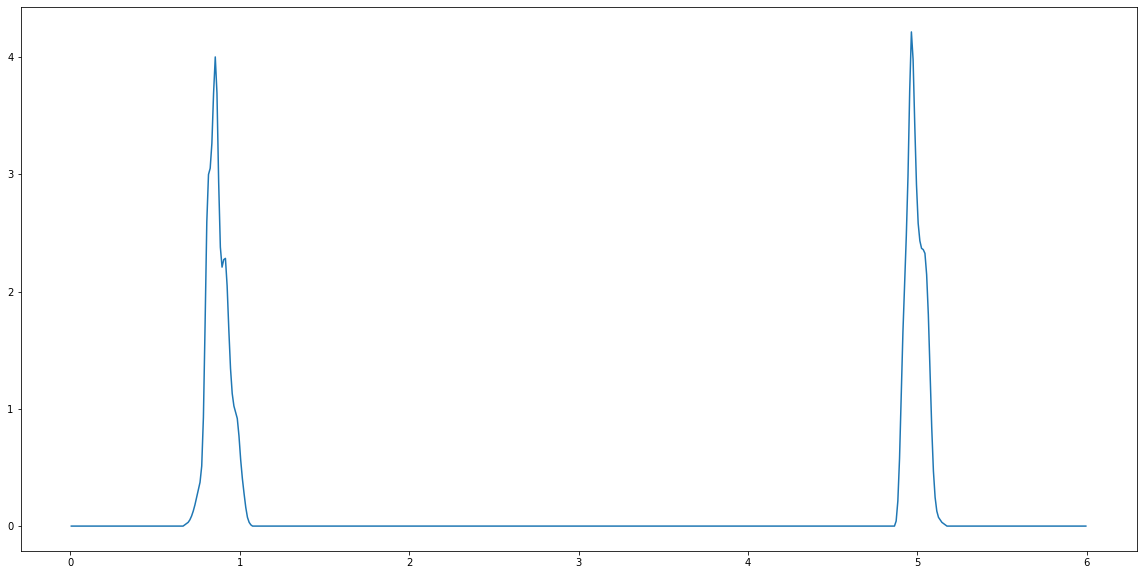

In [91]:
print(opp_samples['Z'][np.argmin(diff),0])
plt.figure()
plt.plot(pdz_bins, opdz[np.argmin(diff)])

Bueno, los peores son bimodales, y el valor Z es la media, es de esperar.

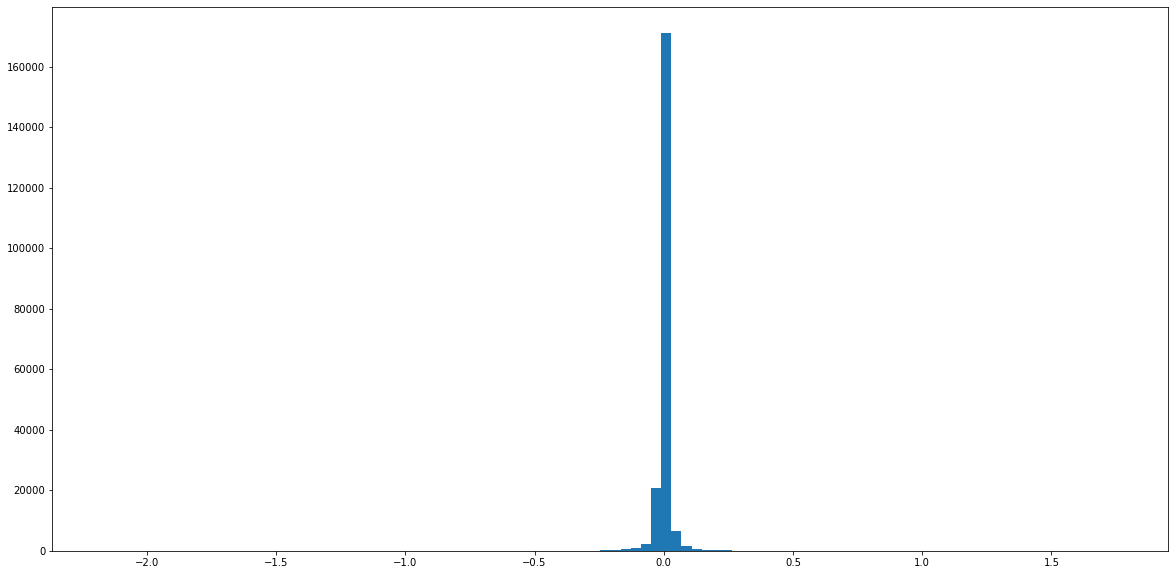

In [92]:
plt.figure()
plt.hist(diff, bins=100)
plt.show()

# Selection

In [95]:
table = Table(photo, copy=True)
table.add_column(Column(
    np.average(
        np.repeat(pdz_bins[np.newaxis,:], len(photo), axis=0),
        weights=opdz[photo['ID']], 
        axis=1
    ), 'Z')
)
len(table)

100089

In [96]:
idx = np.arange(len(table))
np.random.shuffle(idx)
nref = int(len(idx) * 0.9)
ref_idx = np.sort(idx[:nref])
target_idx = np.sort(idx[nref:])

ref_table = table[ref_idx]
target_table = table[target_idx]

In [97]:
ref_hdus = fits.HDUList([fits.PrimaryHDU(), fits.BinTableHDU(ref_table, name='NNPZ_PHOTOMETRY')])

for f, ftrans in zip(bands, fbands):
    trans = filter_provider.getFilterTransmission(ftrans)
    trans_col_data = [
        table.Column(trans[:, 0]),
        table.Column(trans[:, 1])
    ]
    ref_hdus.append(fits.BinTableHDU(
        Table(trans_col_data, names=['Wavelength', 'Transmission']),
        name=f'Flux_{f}'
    ))

ref_hdus.writeto('/home/aalvarez/Work/Data/WillPP/Reference.fits', overwrite=True)

In [98]:
target_table.write('/home/aalvarez/Work/Data/WillPP/Target.fits', overwrite=True)

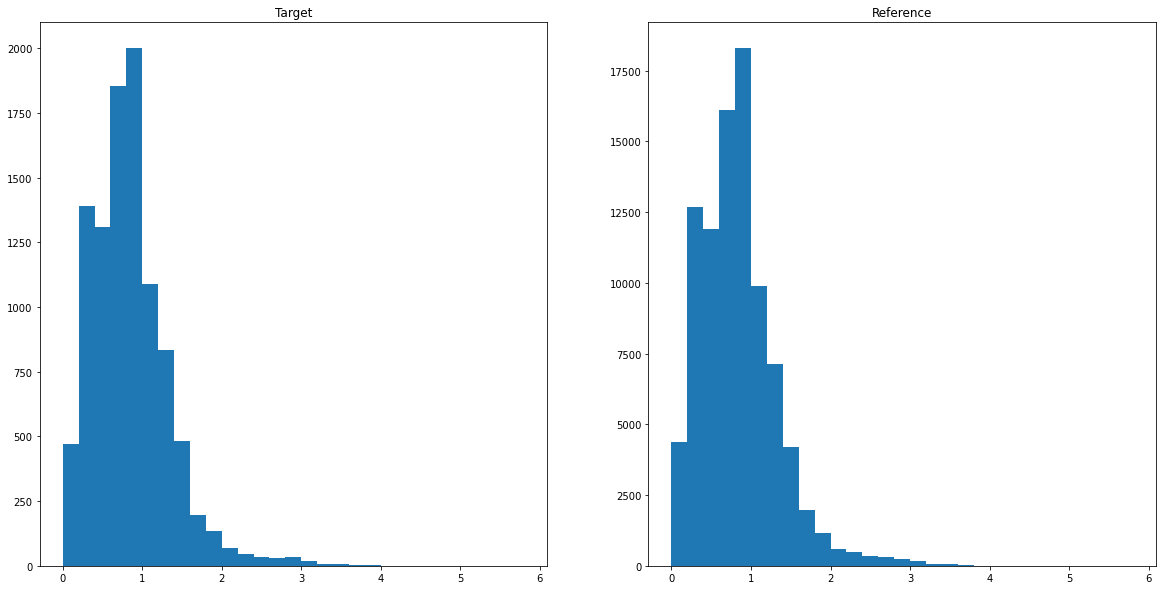

In [99]:
fig, axes = plt.subplots(ncols=2)
axes[0].hist(target_table['Z'], bins=np.arange(0., 6., 0.2))
axes[0].set_title('Target')
axes[1].hist(ref_table['Z'], bins=np.arange(0., 6., 0.2))
axes[1].set_title('Reference')
plt.show()

# Generate full ref sample

In [100]:
try:
    shutil.rmtree('/home/aalvarez/Work/Data/WillPP/ReferenceSample')
except:
    pass

ref = ReferenceSample.createNew('/home/aalvarez/Work/Data/WillPP/ReferenceSample', providers={})
ref.addProvider('PdzProvider', 'pdz', 'pdz_data_{}.npy', ref_table['ID'], np.vstack([pdz_bins, opdz[ref_table['ID']]]))
ref.addProvider('MontecarloProvider', 'pp', 'pp_data_{}.npy', ref_table['ID'], opp_samples[ref_table['ID']])

In [101]:
ref.flush()

In [102]:
diff = []
idxs = []
for oid in tqdm(ref.getIds()):
    diff.append(np.average(pdz_bins, weights=opdz[oid]) - np.average(pdz_bins, weights=ref.getPdzData(oid)[:,1]))
    idxs.append(idx)

In [103]:
np.min(diff), np.max(diff)

(-1.0497711366852513e-08, 1.4070348886008333e-08)

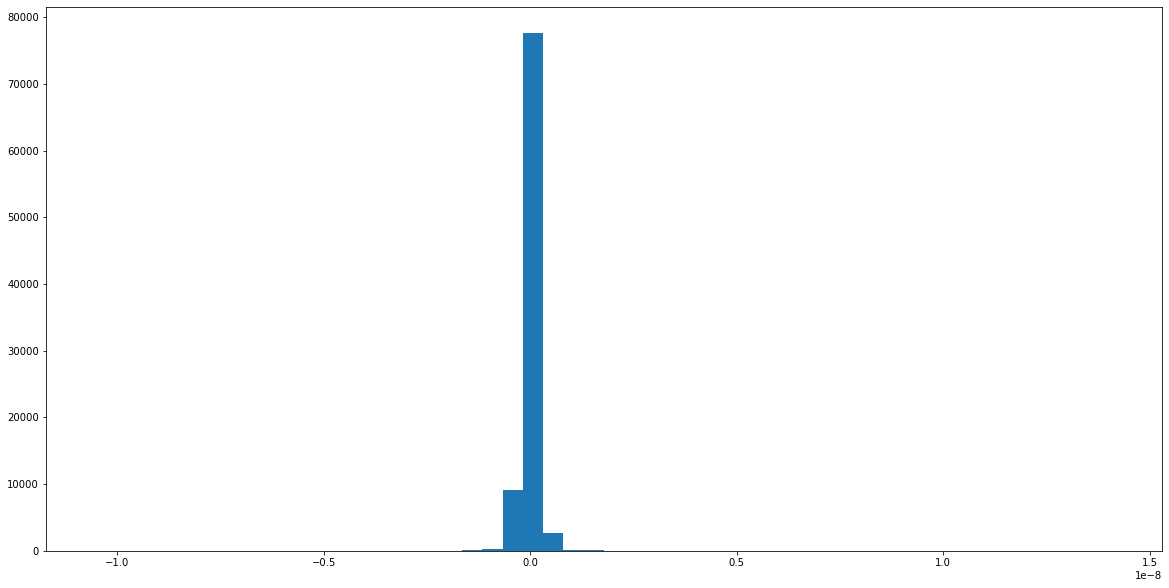

In [104]:
plt.figure()
plt.hist(diff, bins=50)
plt.show()